# COURSE: A deep understanding of deep learning
## SECTION: Metaparameters (activation, batch, optimizers)
### LECTURE: CodeChallenge: Minibatch size in the wine dataset
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202210

In [2]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for timing computations
import time

# for data visualization
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

C:\Users\lucan\AppData\Local\Temp\ipykernel_7268\574432088.py:23: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# Import and process the data

In [3]:
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200] # drop a few outliers

# z-score all columns except for sugar
cols2zscore = data.keys()
# cols2zscore = cols2zscore.drop('residual sugar')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

# Normalize output
### NORMALIZING INCREASES OVERFITTING A LOT NOT SURE WHY
# data['residual sugar'] = stats.zscore(data['residual sugar'].values)    # data['residual sugar'].apply(stats.zscore) gives an error??

# Re-organize the data: train/test in DataLoaders

In [11]:
# convert from pandas dataframe to tensor
dataT  = torch.tensor( data[cols2zscore].drop(columns='residual sugar').values ).float()
labels = torch.tensor( data['residual sugar'].values ).float()
labels = labels[:,None] # transform to matrix

In [12]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = TensorDataset(train_data,train_labels)
test_dataDataset  = TensorDataset(test_data,test_labels)

# Now for the DL part

In [13]:
# create a class for the model

class ANNwine(nn.Module):
  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(11,32)
    
    ### hidden layer 1
    self.bnorm1 = nn.BatchNorm1d(32)
    self.fc1 = nn.Linear(32,64)

    ### hidden layer 2
    self.bnorm2 = nn.BatchNorm1d(64)
    self.fc2 = nn.Linear(64,16)

    ### output layer
    self.output = nn.Linear(16,1)

  # forward pass
  def forward(self,x):

    # input (x starts off normalized)
    x = F.relu( self.input(x) )

    ### hidden layer 1
    # Normalize, weights, activate
    x = F.relu(self.fc1(self.bnorm1(x)))

    ### hidden layer 2
    # Normalize, weights, activate
    x = F.relu(self.fc2(self.bnorm2(x)))

    # output layer
    ### NO ACTIVATION FUNCTION?
    return self.output(x)

# Train the model

In [14]:
# a function that trains the model

# global parameter
numepochs = 1000

def trainTheModel():

  # loss function and optimizer
  lossfun = nn.MSELoss()
  optimizer = torch.optim.SGD(winenet.parameters(),lr=.01)

  # initialize losses
  trainLosses   = torch.zeros(numepochs)
  testLosses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    winenet.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = winenet(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute training accuracy for this batch
      # batchAcc.append( 100*torch.mean(torch.isclose(yHat, y, rtol=0.05, atol=0.05).float()).item() )

      y_combined = torch.cat((yHat, y), 1).T
      batchAcc.append( 100 * torch.corrcoef(y_combined)[0, 1].item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    trainLosses[epochi] = np.mean(batchLoss)

    # test accuracy
    winenet.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = winenet(X)
    y_combined = torch.cat((yHat, y), 1).T
    testAcc.append( 100 * torch.corrcoef(y_combined)[0, 1].item() )
    testLosses[epochi] = lossfun(yHat,y)
  
  # function output
  return trainAcc,testAcc,trainLosses,testLosses

# Now for the experiment

In [18]:
# test data
test_loader = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])

# Train data
train_loader = DataLoader(train_dataDataset, batch_size=32, shuffle=True, drop_last=True)

# create and train a model
winenet = ANNwine()
trainAcc,testAcc,trainLosses,testLosses = trainTheModel()

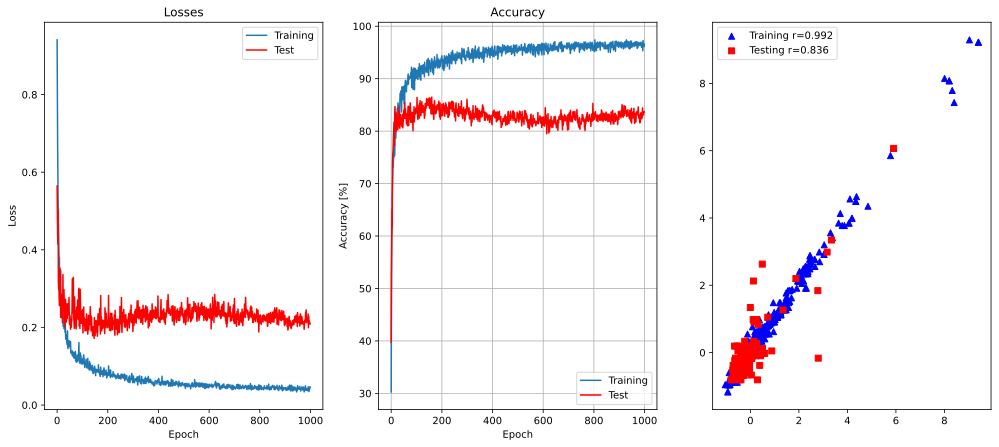

In [34]:
# plot some results
fig,ax = plt.subplots(1,3,figsize=(17,7))

ax[0].plot(trainLosses, label="Training")
ax[0].plot(testLosses, label='Test', color='red')
ax[0].set_title('Losses')
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()

ax[1].plot(trainAcc, label="Training")
ax[1].plot(testAcc, label='Test', color='red')
ax[1].set_title('Accuracy')
ax[1].grid()
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy [%]")
ax[1].legend()


winenet.eval()
# Evaluate training data
yHat = winenet(train_data).detach()
a = ax[2].scatter(yHat, train_labels, color='blue', marker='^', label="Training")
train_corr = np.corrcoef(yHat.numpy().flatten(), train_labels.detach().numpy().flatten())[0, 1]

# Evaluate testing data
yHat = winenet(test_data).detach()
b = ax[2].scatter(yHat, test_labels, color='red', marker='s', label='Test')
test_corr = np.corrcoef(yHat.numpy().flatten(), test_labels.detach().numpy().flatten())[0, 1]

ax[2].legend([a,b], [f'Training r={train_corr:.3f}', f'Testing r={test_corr:.3f}'])

plt.show()

(1597, 12)
(24, 24)
1597


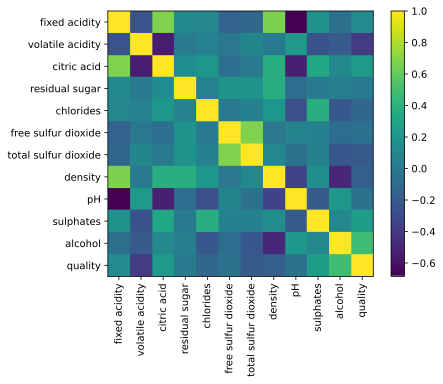

In [20]:
corr = np.corrcoef(data.T, data.T)
print(data.shape)
print(corr.shape)
print(len(labels))

plt.figure()

plt.imshow(data.corr())
plt.xticks(range(len(data.keys())), data.keys(), rotation=90)
plt.yticks(range(len(data.keys())), data.keys())
plt.colorbar()

plt.show()